<a href="https://colab.research.google.com/github/WisdomerLee/Pytorch/blob/main/12PyTorchLayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PyTorch Layer 이해하기
예제 불러오기

In [ ]:
import torch
from torchvision import datasets, transforms

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset', train=True, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor()
                  ])),
    batch_size=1)

In [ ]:
image, label = next(iter(train_loader))

In [ ]:
image.shape, label.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

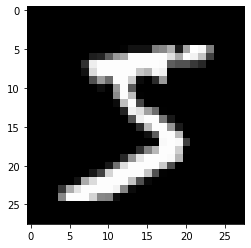

In [ ]:
plt.imshow(image[0,0,:,:], 'gray')
plt.show()

각 Layer 별 설명
Network 쌓기 위한 준비

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Convolution
in_channels:받게될 channel 갯수
out_channels: 보내고 싶은 channel 갯수
kernel_size: 만들고 싶은 kernel(weights)의 크기

In [ ]:
nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [ ]:
layer = nn.Conv2d(1,20,5,1).to(torch.device('cpu'))
layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

weight 시각화를 위해 slice하고 numpy화

In [ ]:
weight= layer.weight
weight.shape

torch.Size([20, 1, 5, 5])

여기서 weight는 학습 가능한 상태: 바로 numpy로 뽑을 수 없음
detach()메소드는 그래프에서 잠깐 빼어 gradient에 영향을 받지 않게..

In [ ]:
weight=weight.detach().numpy()

In [ ]:
weight.shape

(20, 1, 5, 5)

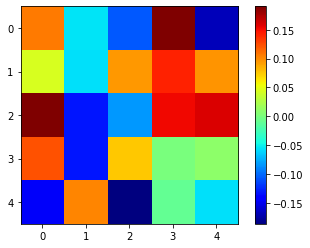

In [ ]:
plt.imshow(weight[0,0,:,:], 'jet')
plt.colorbar()
plt.show()

output 시각화 준비를 위해 numpy화

In [ ]:
output_data= layer(image)

In [ ]:
output_data = output_data.data

In [ ]:
output = output_data.cpu().numpy()

In [ ]:
output.shape

(1, 20, 24, 24)

input으로 들어간 이미지 numpy화

In [ ]:
image_arr=image.numpy()
image_arr.shape

(1, 1, 28, 28)

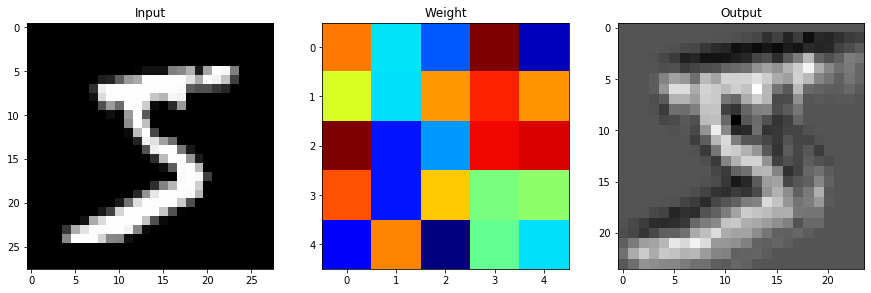

In [ ]:
plt.figure(figsize=(15,30))
plt.subplot(131)
plt.title('Input')
plt.imshow(np.squeeze(image_arr), 'gray')
plt.subplot(132)
plt.title('Weight')
plt.imshow(weight[0,0,:,:], 'jet')
plt.subplot(133)
plt.title('Output')
plt.imshow(output[0,0,:,:], 'gray')
plt.show()

Pooling
input을 앞에 넣고 뒤에 kernel크기, stride를 순서대로

In [ ]:
image.shape

torch.Size([1, 1, 28, 28])

In [ ]:
pool = F.max_pool2d(image, 2,2)
pool.shape

torch.Size([1, 1, 14, 14])

MaxPool Layer는 weight가 없으므로 바로 numpy()가 가능

In [ ]:
pool_arr=pool.numpy()
pool_arr.shape

(1, 1, 14, 14)

In [ ]:
image_arr.shape

(1, 1, 28, 28)

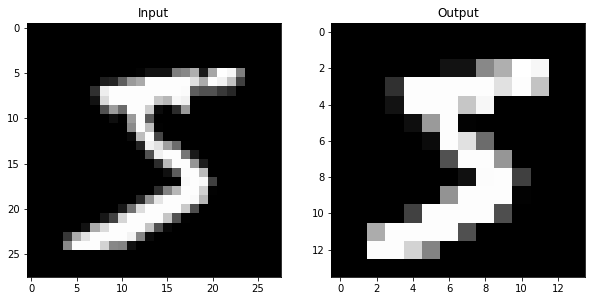

In [ ]:
plt.figure(figsize=(10,15))
plt.subplot(121)
plt.title('Input')
plt.imshow(np.squeeze(image_arr), 'gray')
plt.subplot(122)
plt.title('Output')
plt.imshow(np.squeeze(pool_arr), 'gray')
plt.show()

Linear
nn.Linear: 2d가 아니라 1d만 들어가므로 .view() 1D로 펼쳐주어야 함

In [ ]:
image.shape

torch.Size([1, 1, 28, 28])

In [ ]:
flatten=image.view(1, 28*28)
flatten.shape

torch.Size([1, 784])

In [ ]:
lin = nn.Linear(784,10)(flatten)
lin.shape

torch.Size([1, 10])

In [ ]:
lin

tensor([[-0.0434,  0.0277,  0.1063,  0.1609,  0.1431,  0.2309,  0.1346,  0.4388,
         -0.0121, -0.0381]], grad_fn=<AddmmBackward>)

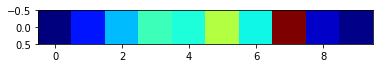

In [ ]:
plt.imshow(lin.detach().numpy(), 'jet')
plt.show()

Softmax
결과를 numpy로 꺼내기 위해 weight가 담긴 Linear에 weight를 꺼주어야 함

In [ ]:
with torch.no_grad():
    flatten=image.view(1,28*28)
    lin=nn.Linear(784,10)(flatten)
    softmax=F.softmax(lin, dim=1)

In [ ]:
softmax

tensor([[0.0697, 0.1198, 0.1297, 0.0978, 0.0897, 0.1263, 0.1136, 0.0836, 0.0888,
         0.0811]])

In [ ]:
np.sum(softmax.numpy())

1.0

Layer 쌓기
예제 출처: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#id23

nn과 nn.functional의 차이
nn: 학습 파라미터가 담긴 것
nn.functional: 학습 파라미터가 없는 것

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,20,5,1)
        self.conv2 = nn.Conv2d(20, 50, 5,1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
    
    def forward(self, x):
        #Feature Extraction
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        
        #Fully Connected(Classfication)
        x = x.view(-1, 4*4*50)
        x= F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

image를 model에 넣어서 결과 확인

In [ ]:
model= Net()

In [ ]:
result = model.forward(image)

In [ ]:
result

tensor([[-2.3574, -2.2095, -2.2973, -2.3019, -2.3104, -2.3577, -2.2856, -2.2299,
         -2.3526, -2.3357]], grad_fn=<LogSoftmaxBackward>)

In [ ]:
model.conv1(image)

tensor([[[[ 0.1285,  0.1285,  0.1285,  ...,  0.1285,  0.1285,  0.1285],
          [ 0.1285,  0.1285,  0.1285,  ...,  0.0490,  0.0106,  0.0372],
          [ 0.1285,  0.1285,  0.1285,  ...,  0.2341,  0.1608,  0.1133],
          ...,
          [ 0.1891,  0.2999,  0.3577,  ...,  0.1285,  0.1285,  0.1285],
          [ 0.1746,  0.2696,  0.4747,  ...,  0.1285,  0.1285,  0.1285],
          [ 0.1982,  0.3380,  0.5236,  ...,  0.1285,  0.1285,  0.1285]],

         [[ 0.1476,  0.1476,  0.1476,  ...,  0.1476,  0.1476,  0.1476],
          [ 0.1476,  0.1476,  0.1476,  ...,  0.0755,  0.0970,  0.0981],
          [ 0.1476,  0.1476,  0.1476,  ..., -0.0024,  0.0092,  0.0713],
          ...,
          [ 0.2664,  0.4263,  0.5148,  ...,  0.1476,  0.1476,  0.1476],
          [ 0.1853,  0.2204,  0.1986,  ...,  0.1476,  0.1476,  0.1476],
          [ 0.0506, -0.2042, -0.4697,  ...,  0.1476,  0.1476,  0.1476]],

         [[-0.1505, -0.1505, -0.1505,  ..., -0.1505, -0.1505, -0.1505],
          [-0.1505, -0.1505, -